### Acquiring and processing data ###

In [1]:
import json
import pandas as pd
import re

input_file = 'C:\\Users\\rohit\\Desktop\\HiWi\Work\\Radar Sensor Project\\py_mmwave_dev\\py_mmwave_plot\\log\\robomaster_node_x_mmwave_sensor_20240723_170609.txt'

match = re.search(r'sensor_(\d{8}_\d{6})', input_file)
if match:
    timestamp_part = match.group(1)
else:
    raise ValueError("No timestamp found in the input file path")

#output_file = f'{timestamp_part}_parsed_data.csv'


#Initializing
data_list = []

#Read data file and parse the JSON data
with open(input_file, 'r') as file:
    for line in file:
        data = json.loads(line.strip())
        timestamp = data['timestamp']
        numObj = data['numObj']
        
        # Create a row for each object
        for i in range(numObj):
            row = {
                'timestamp': timestamp,
                'range': data['range'][i],
                'azimuth': data['azimuth'][i],
                'elevation': data['elevation'][i],
                'x': data['x'][i],
                'y': data['y'][i],
                'z': data['z'][i],
                'v': data['v'][i],
                'snr': data['snr'][i],
                'rangeProfile': data['rangeProfile'],
            }
            data_list.append(row)

#list of dictionaries to pandas DataFrame
df = pd.DataFrame(data_list)

#Displaying DataFrame
print(df.head())

#CSV output of DataFrame
#df.to_csv(output_file, index=False)

print(df.timestamp)
print(df.range)
print(df.azimuth)

      timestamp     range    azimuth  elevation      x      y      z    v  \
0  1.721747e+09  0.697293 -26.452780  10.912134 -0.305  0.613  0.132  0.0   
1  1.721747e+09  1.919075  -9.365245  16.125244 -0.300  1.819  0.533  0.0   
2  1.721747e+09  2.921451 -11.081350  12.594075 -0.548  2.798  0.637  0.0   
3  1.721747e+09  3.968269 -50.698015  14.267841 -2.976  2.436  0.978  0.0   
4  1.721747e+09  0.697293 -26.452780  10.912134 -0.305  0.613  0.132  0.0   

    snr                                       rangeProfile  
0  16.3  [25.431, 32.941, 36.28, 35.998, 32.659, 27.328...  
1  16.1  [25.431, 32.941, 36.28, 35.998, 32.659, 27.328...  
2  25.4  [25.431, 32.941, 36.28, 35.998, 32.659, 27.328...  
3  12.3  [25.431, 32.941, 36.28, 35.998, 32.659, 27.328...  
4  16.3  [25.493, 32.957, 36.296, 35.982, 32.674, 27.39...  
0        1.721747e+09
1        1.721747e+09
2        1.721747e+09
3        1.721747e+09
4        1.721747e+09
             ...     
10984    1.721747e+09
10985    1.721747

### Visualizing the Radar PtCloud Data ###

#### Interpolated Count based 2D Histogram ####

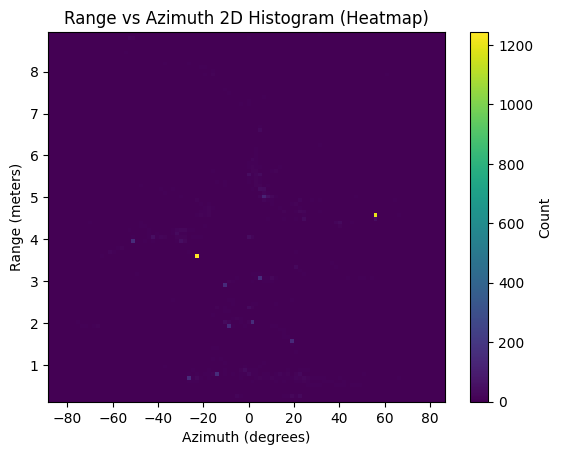

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.hist2d(df['azimuth'], df['range'], bins=[100, 100], cmap='viridis')

plt.colorbar(label='Count')

plt.xlabel('Azimuth (degrees)')
plt.ylabel('Range (meters)')
plt.title('Range vs Azimuth 2D Histogram (Heatmap)')

plt.show()

#### Interpolated SNR-based Azimuth-Range Heatmap ####

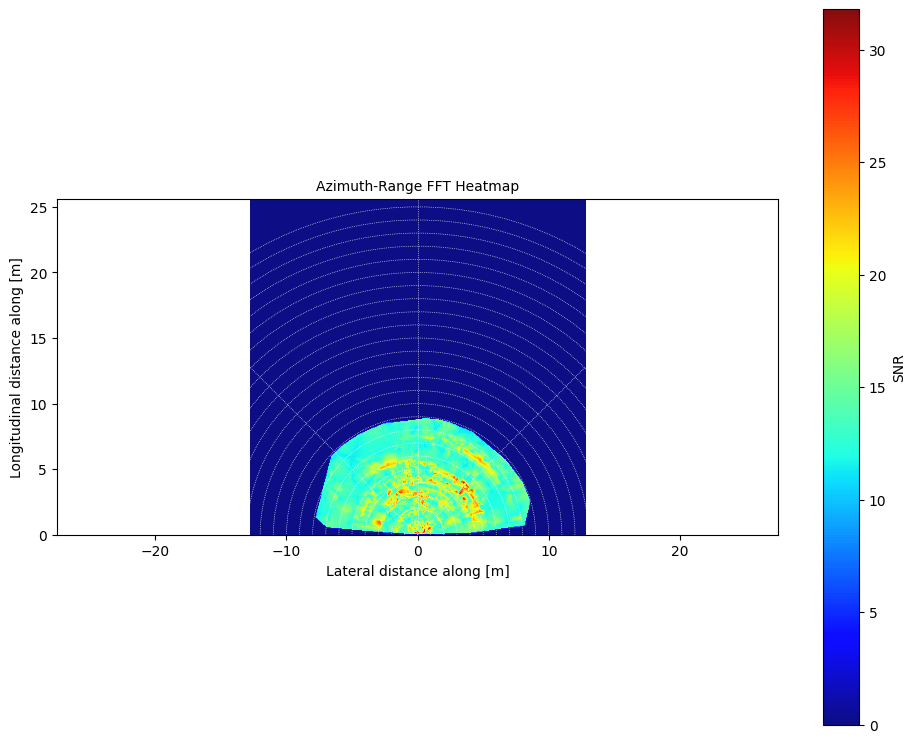

In [3]:
import scipy.interpolate as spi
import matplotlib.patches as pat
import matplotlib.widgets as wgt
#other libraries already imported previously

#Parameters
tx_azimuth_antennas = 4  
rx_antennas = 3  
range_bins = 256
angle_bins = 64
range_res = 0.1  
range_bias = 0.0 

#coordinates
t = np.linspace(-1, 1, angle_bins)
t = np.arcsin(t)
r = np.linspace(0, range_bins * range_res, range_bins)

range_depth = range_bins * range_res
range_width, grid_res = range_depth / 2, 400

xi = np.linspace(-range_width, range_width, grid_res)
yi = np.linspace(0, range_depth, grid_res)
xi, yi = np.meshgrid(xi, yi)

# x & y values for bins
x = np.outer(r, np.sin(t))
y = np.outer(r, np.cos(t))
y = y - range_bias

#Interpolating
azimuth_radians = np.radians(df['azimuth'])
x_points = df['range'] * np.sin(azimuth_radians)
y_points = df['range'] * np.cos(azimuth_radians)
values = df['snr']

#Interpolating with SNR values
zi = spi.griddata((x_points, y_points), values, (xi, yi), method='linear')
zi = np.nan_to_num(zi)  # Replace NaN values with zero

#Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)

fig.tight_layout(pad=2)

cm = ax.imshow(zi[::-1, ::-1], cmap=plt.cm.jet, extent=[-range_width, range_width, 0, range_depth], alpha=0.95)
cursor = wgt.Cursor(ax, useblit=True, color='white', linewidth=1)

ax.set_title('Azimuth-Range FFT Heatmap', fontsize=10)
ax.set_xlabel('Lateral distance along [m]')
ax.set_ylabel('Longitudinal distance along [m]')

ax.plot([0, 0], [0, range_depth], color='white', linewidth=0.5, linestyle=':', zorder=1)
ax.plot([0, -range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)
ax.plot([0, +range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)

# Range circles
for i in range(1, int(range_depth)+1):
    ax.add_patch(pat.Arc((0, 0), width=i*2, height=i*2, angle=90, theta1=-90, theta2=90, color='white', linewidth=0.5, linestyle=':', zorder=1))

plt.colorbar(cm, ax=ax, label='SNR')
plt.show() 

#### RangeProfile ####

8.939672980596104


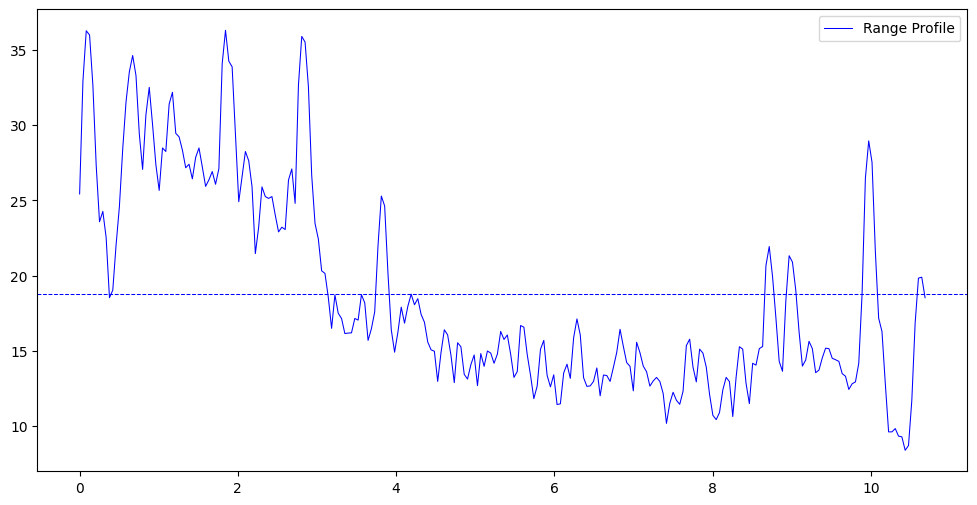

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def update(df, range_max=100, range_bias=0):
    ax.clear()

    if 'rangeProfile' in df.columns:
        y = df['rangeProfile'].values[0]  # Assuming you're interested in the first row for simplicity
        bin_size = range_max / len(y)
        x = [i * bin_size for i in range(len(y))]
        x = [v - range_bias for v in x]
        ax.plot(x, y, color='blue', linewidth=0.75, label='Range Profile')
        ax.axhline(y=np.mean(y), color='blue', linestyle='--', linewidth=0.75)
      
    ax.legend()

# Plotting data
def start_plot(df, range_bias=0):
    fig = plt.figure(figsize=(12, 6))
    global ax
    ax = plt.subplot(1, 1, 1)
    
    fig.canvas.manager.set_window_title('Range Profile')
                           
    ax.set_title('Range Profile', fontsize=10)
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Relative power [dB]')
    
    # value for max range plot
    max_range_value = df['range'].max()
    print(max_range_value)
    range_max = max_range_value * 1.2  # Adding 20% buffer to range values
    
    ax.set_xlim([0, range_max])
    ax.set_ylim([0, 100])
    ax.set_yticks(range(0, 101, 10))
    ax.grid(linestyle=':')
    
    update(df, range_max, range_bias)
    
    plt.show()

start_plot(df)